# Imports

In [1]:
import sys
sys.path.insert(1, "..")
from collections import namedtuple
import dill
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import get_full_kernels_in_kernel_expression
from globalParams import options
import gpytorch
import itertools
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from metrics import calculate_AIC as AIC, calculate_BIC as BIC, calculate_laplace as Laplace, NestedSampling as Nested, log_normalized_prior, prior_distribution
import numpy as np
import os
import pandas as pd
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch
import re
import torch

# Seed

In [2]:
torch.manual_seed(42)


# Data generation

In [3]:
import data_functions

## 1D

In [4]:
DatasetInfo = namedtuple('DatasetInfo', ['name', 'path', 'dimension', 'description'])
datasets_1d = {
    "alternating" : DatasetInfo('alternating', 'datasets/alternating.csv', 1, 'Alternates between high and low'),
    "alternating16" : DatasetInfo('alternating', 'datasets/alternating_16.csv', 1, 'Alternates between high and low'),
    "broaden" : DatasetInfo('broaden', 'datasets/broaden.csv', 1, 'Data with increasing variance'),
    "large gap" : DatasetInfo('large gap', 'datasets/large_gap.csv', 1, 'Contains large gap between X values'),
    "linear outlier" : DatasetInfo('linear outlier', 'datasets/linear_outlier.csv', 1, 'Linear data with outlier in last entry'),
    "parabola" : DatasetInfo('parabola', 'datasets/parabola.csv', 1, 'Parabola'),
    "periodic linear" : DatasetInfo('periodic linear', 'datasets/periodic_linear.csv', 1, 'Periodic data that changes to becoming purely linear'),
    "periodic" : DatasetInfo('periodic', 'datasets/periodic.csv', 1, 'Periodic data'),
    "periodic_1D flattened" : DatasetInfo('periodic', 'datasets/periodic_1D flattened.csv', 1, 'Copy of the 2D dataset that effectively only happens on the X axis'),
    "v_lines" : DatasetInfo('v_lines', 'datasets/v_lines.csv', 1, 'Vertical lines'),
}

## 2D

In [5]:
# named tuple or dictionary for the datasets, same as 1D case
DatasetInfo = namedtuple('DatasetInfo', ['name', 'path', 'dimension', 'description'])
datasets_2d = {
    "away": DatasetInfo('away', 'datasets/2D/away.csv', 2, 'Away from the center'),
    "bullseye": DatasetInfo('bullseye', 'datasets/2D/bullseye.csv', 2, 'Two circles forming a bullseye'),
    "circle": DatasetInfo('circle', 'datasets/2D/circle.csv', 2, 'Circle'),
    "dots": DatasetInfo('dots', 'datasets/2D/dots.csv', 2, 'An equidistant dot grid'),
    "dots favouring lower values": DatasetInfo('dots favouring lower values', 'datasets/2D/dots favouring lower values.csv', 2, 'An equidistant dot grid where the high point of Periodic_1D is alone and there are multiple duplicates of the low values'),
    "dots minimal": DatasetInfo('dots minimal', 'datasets/2D/dots minimal.csv', 2, 'An equidistant dot grid with 9 points'),
    "dots minimal no shift": DatasetInfo('dots minimal', 'datasets/2D/dots minimal no shift.csv', 2, 'An equidistant dot grid with 9 points'),
    "dots minimal shifted": DatasetInfo('dots minimal', 'datasets/2D/dots minimal shifted.csv', 2, 'An equidistant dot grid with 9 points, all shifted by 0.5 to each other'),
    "dots minimal shifted to zero": DatasetInfo('dots minimal', 'datasets/2D/dots minimal shifted to zero.csv', 2, 'Basically "dots minimal shifted", but such that zero is the centre.'),
    "dots minimal shifted around zero": DatasetInfo('dots minimal', 'datasets/2D/dots minimal shifted around zero.csv', 2, 'An equidistant dot grid with 9 points, centred around zero.'),
    "line": DatasetInfo('line', 'datasets/2D/line.csv', 2, 'One diagonal line across X-Y'),
    "line X": DatasetInfo('line', 'datasets/2D/line X.csv', 2, 'One diagonal line that strictly follows X'),
    "line Y": DatasetInfo('line', 'datasets/2D/line Y.csv', 2, 'One diagonal line that strictly follows Y'),
    "line 05X1Y": DatasetInfo('line', 'datasets/2D/line 05X1Y.csv', 2, 'One diagonal line across X-Y, where X is 0.5 slower than Y'),
    "h_lines": DatasetInfo('h_lines', 'datasets/2D/h_lines.csv', 2, 'Horizontal lines'),
    "high lines": DatasetInfo('high lines', 'datasets/2D/high_lines.csv', 2, 'Horizontal lines with a large gap between them'),
    "slant down": DatasetInfo('slant down', 'datasets/2D/slant_down.csv', 2, 'Straight lines slanting downwards'),
    "slant up": DatasetInfo('slant up', 'datasets/2D/slant_up.csv', 2, 'Straight lines slanting upwards'),
    "star": DatasetInfo('star', 'datasets/2D/star.csv', 2, 'Star shape'),
    "v_lines": DatasetInfo('v_lines', 'datasets/2D/v_lines.csv', 2, 'Vertical lines'),
    "wide lines": DatasetInfo('wide lines', 'datasets/2D/wide_lines.csv', 2, 'Vertical lines with a large gap between them'),
    "x_shape": DatasetInfo('x_shape', 'datasets/2D/x_shape.csv', 2, 'X shape'),
}

# Helper functions

In [6]:
from helper_functions import *

# Plotting functions

In [7]:
from plotting_functions import *

## Training

## Nested

## 1D

## 2D

## GP definition

In [8]:
from gp_classes import *

# Various 1D and 2D datasets 

## 1D data

In [ ]:
possible_kenels = [
    "SE",
    "C*SE",
    "C*C*SE",
    "LIN",
    "C*LIN",
    "LIN*SE",
    "LIN*PER",
    "SE+SE",
    "RQ",
    "PER",
    "PER*SE",
    "PER+SE",
    "PER+C*SE",
    "C*PER",
    "MAT32",
    "MAT32+MAT52",
    "MAT32*PER",
    "MAT32+PER",
    "MAT32*SE",
    "MAT32+SE",
    "MAT52",
    "MAT52*PER",
    "MAT52+SE",
    "SE*SE",
    "(SE+RQ)*PER",
    "SE+SE+SE",
    "MAT32+(MAT52*PER)"]

possible_datasets = [
   "alternating",
   "broaden",
   "large gap",
   "linear outlier",
   "parabola",
   "periodic linear",
   "periodic",
   "periodic_1D flattened",
   "v_lines"
]

In [ ]:
data_functions.list_available_patterns()

In [ ]:
kernel_name = "C*PER"

input_pattern_str = "alternating16" # "linear" or one of the datasets_1d keys
input_pattern = input_pattern_str
input_pattern = datasets_1d[input_pattern_str].path  #datasets_1d[XYZ].path or "linear" or ...
input_dim = 1 # usually datasets_1d[XYZ].path 
input_target_dim = 0
# Optional input arguments
START = -5
END = 5

output_pattern_str = "alternating16"#input_pattern_str#"sin(x) + 3"
output_pattern = datasets_1d[output_pattern_str].path #datasets_1d[dataset_name].path or lambda x:sin(x) or ...
#output_pattern = lambda x: x
output_dim = 1 # usually datasets_1d[XYZ].path
output_target_dim = 1

num_points = 11

data_generator = data_functions.DataGenerator()
train_x = data_generator.generate_inputs(input_pattern, n_points=num_points, START=START, END=END, target_dim=input_target_dim)
train_y = data_generator.generate_labels(train_x, output_pattern, n_dim=output_dim, target_dim=output_target_dim)

#train_x = data_generator.generate_inputs("linear", n_points=51, START=-5, END=5)
##train_y = data_generator.generate_labels(train_x, "periodic_1D")
#train_y = data_generator.generate_labels(train_x, pattern=lambda x: torch.sin(x), target_dim=None)

logarithmic_reinit=True
data_norm_x = False
data_norm_y = False 
levels = [1e+5]
uninformed = True

if data_norm_x:
    train_x = data_functions.Transformations.z_score(train_x)
if data_norm_y:
    train_y = data_functions.Transformations.z_score(train_y)

In [ ]:
print(f"{'y scaled' if data_norm_y else 'y unscaled'} {output_pattern_str} - {'x scaled' if data_norm_x else 'x unscaled'} {input_pattern_str} - {kernel_name} - {len(train_x)} - {'uninformed' if uninformed else 'informed'}")


In [ ]:
log_path = f"logs/{'x-normalized' if data_norm_x else ''}_{input_pattern}/{kernel_name}"
if not os.path.exists(log_path):
    os.makedirs(log_path)

In [ ]:
fig, ax = plot_data(train_x, train_y, title_add=output_pattern, return_figure=True)
fig.savefig(f"{log_path}/data.png", bbox_inches='tight')
#fig.savefig(f"{log_path}/data.pgf", bbox_inches='tight')

In [ ]:
print(train_x)
print(train_y)

In [ ]:
one_dim_data = (train_x, train_y)

In [ ]:
print(min(train_y))
print(max(train_y))
print(min(train_x))
print(max(train_x))

In [ ]:
len(train_x)

In [ ]:
## Define the GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, kernel_text=kernel_name)
likelihood_MAP = gpytorch.likelihoods.GaussianLikelihood()
model_MAP = ExactGPModel(train_x, train_y, likelihood_MAP, kernel_text=kernel_name)

In [ ]:
model

In [ ]:
param_names = [l[0] for l in list(model.named_parameters())]

In [ ]:
random_restarts = 10 

## Train the GPs
model.train()
likelihood.train()
neg_scaled_mll_loss, model, likelihood, mll_train_log = optimize_hyperparameters(model, likelihood, X=train_x, Y=train_y, MAP=False, uninformed=uninformed, random_restarts=random_restarts, verbose=True, logarithmic_reinit=logarithmic_reinit)
mll_opt_params = [p.item() for p in model.parameters() if p.requires_grad]

In [ ]:
# Give me the index of the best training run
best_mll_training_run = np.argmin([min(run) for run in mll_train_log.neg_loss])
best_mll_training_run

In [ ]:
# Plot the optimization path of the trainings, each in an individual plot, given the parameter of interest
# The parameter progression is plotted as arrows pointing to the next parameter position
# The arrows are colored according to the lateness of their progression
# The colorbar shows the progression of the parameter



f, axs = plt.subplots(1, (random_restarts), figsize=(4*(random_restarts), 4), sharey=True, layout="constrained")
if random_restarts == 1:
    axs = [axs]

xdim = 0
ydim = 1
# extract all the parameters
## Likelihood values

#mll_train_log.neg_loss
## Parameters
#mll_train_log.x
parameter_paths = [[log for log in mll_train_log.x[i]] for i in range(len(mll_train_log.x))]
parameter_values = [[log for log in mll_train_log.neg_loss[i]] for i in range(len(mll_train_log.neg_loss))]

for i, ax in enumerate(axs):
    # train log consists of a list of tuples, where the first element is the parameter vector and the second element is the loss
    plot_parameter_progression(parameter_paths[i], losses=parameter_values[i], xlabel=param_names[xdim], ylabel=param_names[ydim], xdim=xdim, ydim=ydim, fig=f, ax=ax, display_figure=False, title_add=f"restart {i}")

In [ ]:
model_MAP.train()
likelihood_MAP.train()
neg_scaled_map_loss, model_MAP, likelihood_MAP, map_train_log = optimize_hyperparameters(model_MAP, likelihood_MAP, X=train_x, Y=train_y, MAP=True, uninformed=uninformed, random_restarts=random_restarts, verbose=True, logarithmic_reinit=logarithmic_reinit)
map_opt_params = [p.item() for p in model_MAP.parameters() if p.requires_grad]

In [ ]:
print([torch.nn.functional.softplus(p) for p in model_MAP.parameters() if p.requires_grad]) 

In [ ]:
# Give me the index of the best training run
best_map_training_run = np.argmin([min(run) for run in map_train_log.neg_loss])
best_map_training_run

### Exploring the PyGRANSO Hessian

In [ ]:
map_train_log.hessians[best_map_training_run]

In [ ]:
torch.linalg.det(map_train_log.hessians[best_map_training_run][-1])

In [ ]:
mll_train_log.hessians[best_mll_training_run][-1]

In [ ]:


f, axs = plt.subplots(1, (random_restarts), figsize=(4*(random_restarts), 4), sharey=True, layout="constrained")
if random_restarts == 1:
    axs = [axs]

# extract all the parameters
parameter_paths = [[log for log in map_train_log.x[i]] for i in range(len(map_train_log.x))]
parameter_values = [[log for log in map_train_log.neg_loss[i]] for i in range(len(map_train_log.neg_loss))]

xdim = 0
ydim = 2

for i, ax in enumerate(axs):
    plot_parameter_progression(parameter_paths[i], losses=parameter_values[i], xlabel=param_names[xdim], ylabel=param_names[ydim], xdim=xdim, ydim=ydim, fig=f, ax=ax, display_figure=False, title_add=f"restart {i}")

In [ ]:
one_dim_train_log = map_train_log 

In [ ]:
# One dimensional case:
#Final best parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
#tensor([-11.6140], requires_grad=True)), ('covar_module.kernels.0.raw_lengthscale', Parameter containing:
#tensor([[-0.3335]], requires_grad=True)), ('covar_module.kernels.1.raw_lengthscale', Parameter containing:
#tensor([[-0.3335]], requires_grad=True))] w. loss: 0.6454170942306519 (smaller=better)
# Two dimensional case:
#Final best parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
#tensor([-11.7261], requires_grad=True)), ('covar_module.base_kernel.kernels.0.raw_lengthscale', Parameter containing:
#tensor([[-0.3326]], requires_grad=True)), ('covar_module.base_kernel.kernels.1.raw_lengthscale', Parameter containing:
#tensor([[-0.3326]], requires_grad=True))] w. loss: 0.6454619765281677 (smaller=better)

#fixed_reinit(model_MAP, torch.tensor([-11.7261, -0.3326, -0.3326]))

In [ ]:
one_dim_mean_vec = model_MAP(train_x).mean
one_dim_cov_matr = model_MAP(train_x).covariance_matrix


In [ ]:
model.eval()
likelihood.eval()
model_MAP.eval()
likelihood_MAP.eval()

In [ ]:
model_MAP(train_x)

In [ ]:
one_dim_post_mean_vec = model_MAP(train_x).mean
one_dim_post_cov_matr = model_MAP(train_x).covariance_matrix

In [ ]:
model.eval()
likelihood.eval()
model_MAP.eval()
likelihood_MAP.eval()
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
ax = axs[0]
ax_MAP = axs[1]
plot_model(model, likelihood, train_x, train_y, return_figure=False, figure=fig, ax=ax, loss_val=neg_scaled_mll_loss.item(), loss_type="mll", display_figure=False)
plot_model(model_MAP, likelihood_MAP, train_x, train_y, return_figure=False, figure=fig, ax=ax_MAP, loss_val=neg_scaled_map_loss.item(), loss_type="map")
fig.savefig(f"{log_path}/posterior.png", bbox_inches='tight')
#fig.savefig(f"{log_path}/posterior.pgf", bbox_inches='tight')
model.train()
likelihood.train()
model_MAP.train()
likelihood_MAP.train()

In [ ]:
neg_scaled_map_loss

In [ ]:
model.train()
likelihood.train()
model_MAP.train()
likelihood_MAP.train()

In [ ]:
pos_unscaled_MLL = -neg_scaled_mll_loss*len(*model.train_inputs)
pos_unscaled_MAP = -neg_scaled_map_loss*len(*model.train_inputs)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

bool_use_finite_difference_hessian = True

## Calculate the metrics
AIC_val, AIC_logs = AIC(pos_unscaled_MLL, num_params)
BIC_val, BIC_logs = BIC(pos_unscaled_MLL, num_params, torch.tensor(len(train_x)))
AIC_MAP_val, AIC_MAP_logs = AIC(pos_unscaled_MAP, num_params)
BIC_MAP_val, BIC_MAP_logs = BIC(pos_unscaled_MAP, num_params, torch.tensor(len(train_x)))
Lap0_val, Lap0_logs =     Laplace(model_MAP, pos_unscaled_MAP.clone(), uninformed=uninformed, use_finite_difference_hessian=bool_use_finite_difference_hessian, param_punish_term=0)
LapAIC_val, LapAIC_logs = Laplace(model_MAP, pos_unscaled_MAP.clone(), uninformed=uninformed, use_finite_difference_hessian=bool_use_finite_difference_hessian, param_punish_term=-1)
LapBIC_val, LapBIC_logs = Laplace(model_MAP, pos_unscaled_MAP.clone(), uninformed=uninformed, use_finite_difference_hessian=bool_use_finite_difference_hessian, param_punish_term="BIC")

In [ ]:
if any(torch.linalg.eigh(Lap0_logs["Hessian autograd symmetrized"])[0] < 0):
    # Load stop.ascii file and print it
    with open(f"stop.ascii", "r") as f:
        print(f.read())
print(torch.linalg.eigh(Lap0_logs["Hessian autograd symmetrized"])[0])
print(Lap0_logs["Hessian autograd symmetrized"])

In [ ]:
Lap0_logs

In [ ]:
LapAIC_logs

In [ ]:
LapBIC_logs

In [ ]:
model_evidences = list()
model_evidence_logs = list()
uninformed = True

In [ ]:
maxcall = 1e+1
if maxcall in levels:
    print(maxcall)
    nested_pos_model_evidence_e1, Nested_logs_e1 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(nested_pos_model_evidence_e1)
    model_evidence_logs.append(Nested_logs_e1)

In [ ]:
maxcall = 1e+2
if maxcall in levels:
    print(maxcall)
    nested_pos_model_evidence_e2, Nested_logs_e2 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(nested_pos_model_evidence_e2)
    model_evidence_logs.append(Nested_logs_e2)

In [ ]:
maxcall = 1e+3
if maxcall in levels:
    print(maxcall)
    nested_pos_model_evidence_e3, Nested_logs_e3 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(nested_pos_model_evidence_e3)
    model_evidence_logs.append(Nested_logs_e3)

In [ ]:
maxcall = 1e+4
if maxcall in levels:
    print(maxcall)
    nested_pos_model_evidence_e4, Nested_logs_e4 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(nested_pos_model_evidence_e4)
    model_evidence_logs.append(Nested_logs_e4)

In [ ]:
maxcall = 1e+5
if maxcall in levels:
    print(maxcall)
    nested_pos_model_evidence_e5, Nested_logs_e5 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(nested_pos_model_evidence_e5)
    model_evidence_logs.append(Nested_logs_e5)

In [ ]:
for mod_log in model_evidence_logs:
    with open(f"{mod_log['res file']}", "rb") as f:
        res = dill.load(f)
    print(f"Num calls: {sum(res.ncall)}")
    print(f"logz Error: {res["logzerr"][-1]}")

In [ ]:

plot_mll_opt = True
std_filter = None # float as 1e-3 or None
show_last_num = 0.5 # integer, float or None
filter_type = "none" # ("mean"), "max", "none"
xdim = 0
ydim = 1

param_names = [l[0] for l in list(model.named_parameters())]

f, axs = plt.subplots(1, len(levels), figsize=(4*len(levels), 4), sharey=True, layout="constrained")
if len(levels) == 1:
    axs = [axs]
for ax, level, model_evidence_log in zip(axs, levels, model_evidence_logs):
    if ax == axs[-1]:
        nested_sampling_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, show_last_num=show_last_num, return_figure=False, title_add="", fig=f, ax=ax, display_figure=False, plot_mll_opt=plot_mll_opt, mll_opt_params=mll_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "white"], Lap_hess=Lap0_logs["Hessian pre correction"])
    else:
        nested_sampling_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, show_last_num=show_last_num, return_figure=False, title_add="", fig=f, ax=ax, display_figure=False, plot_mll_opt=plot_mll_opt, mll_opt_params=mll_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "white"], Lap_hess=Lap0_logs["Hessian pre correction"])
    if ax == axs[0] or len(levels)==1:
        ax.set_ylabel(param_names[ydim])

In [ ]:

map_opt_params = [p.item() for p in model_MAP.parameters() if p.requires_grad]
plot_map_opt = True
std_filter = None # float as 1e-3 or None
show_last_num = 0.5 # integer, float or None
filter_type = "none" # ("mean"), "max", "none"
xdim = 0
ydim = 1

param_names = [l[0] for l in list(model.named_parameters())]

f, axs = plt.subplots(1, len(levels), figsize=(4*len(levels), 4), sharey=True, layout="constrained")
if len(levels) == 1:
    axs = [axs]
for ax, level, model_evidence_log in zip(axs, levels, model_evidence_logs):
    if ax == axs[-1]:
        posterior_surface_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, show_last_num=show_last_num, return_figure=False, title_add="", fig=f, ax=ax, display_figure=False, plot_mll_opt=plot_map_opt, mll_opt_params=map_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "white"], uninformed=uninformed, Lap_hess=Lap0_logs["Hessian pre correction"])
    else:
        posterior_surface_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, show_last_num=show_last_num, return_figure=False, title_add="", fig=f, ax=ax, display_figure=False, plot_mll_opt=plot_map_opt, mll_opt_params=map_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "white"], uninformed=uninformed, Lap_hess=Lap0_logs["Hessian pre correction"])
    if ax == axs[0] or len(levels)==1:
        ax.set_ylabel(param_names[ydim])

In [ ]:
# Find the best value and the corresponding hyperparameters
best_idx = np.argmax(res.logl)
best_hyperparameters = res.samples[best_idx]

In [ ]:
# Optimal GP according to Nested sampling
fixed_reinit(model, torch.tensor(best_hyperparameters))
model.eval()
likelihood.eval()
# mll of best parameterization according to Nested sampling:
mll_fkt = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
unscaled_pos_nested_top_mll = (mll_fkt(model(train_x), train_y))*len(train_x)
unscaled_pos_nested_top_map = unscaled_pos_nested_top_mll+log_normalized_prior(model)*len(train_x)
fig, ax = plot_model(model, likelihood, train_x, train_y, return_figure=True, loss_val=res.logl[best_idx], loss_type="Nested logl")
ax.title.set_text(f"{ax.title.get_text()} ; MLL: {unscaled_pos_nested_top_mll.item():.2f}; MAP: {unscaled_pos_nested_top_map.item():.2f}\n MLL (u) {-unscaled_pos_nested_top_mll/len(train_x):.2f}; MAP (u) {-unscaled_pos_nested_top_map/len(train_x):.2f}")

In [ ]:
# Collect metric names and values into a list of tuples
metrics_data = [
    ("MLL", f"{pos_unscaled_MLL.item():.3f}"),
    ("MLL (loss)", f"{neg_scaled_mll_loss.item():.3f}"),
    ("AIC", f"{AIC_val.item():.3f}"),
    ("AIC (s)", f"{(AIC_val.item()*(-0.5)):.3f}"),
    ("BIC", f"{BIC_val.item():.3f}"),
    ("BIC (s)", f"{(BIC_val.item()*(-0.5)):.3f}"),
    

]
labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()

metrics_data = [("MAP", f"{pos_unscaled_MAP.item():.3f}"),
    ("MAP (loss)", f"{neg_scaled_map_loss.item():.3f}"),
    ("AIC_M", f"{AIC_MAP_val.item():.3f}"),
    ("AIC_M (s)", f"{(AIC_MAP_val.item()*(-0.5)):.3f}"),
    ("BIC_M", f"{BIC_MAP_val.item():.3f}"),
    ("BIC_M (s)", f"{(BIC_MAP_val.item()*(-0.5)):.3f}"),
]

labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()


metrics_data=[    
    ("Lap", f"{Lap0_logs["laplace without replacement"].item():.3f}"),
    ("Lap0", f"{Lap0_val.item():.3f}"),
    ("LapAIC", f"{LapAIC_val.item():.3f}"),
    ("LapBIC", f"{LapBIC_val.item():.3f}"),
    ]

labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()

metrics_data = [(f"Nested ({level:.1e})", f"{Nested_val:.3f}") 
                for level, Nested_val in zip(levels, model_evidences)]

# Transpose the table: one row for the label, another for the value
labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]

# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")

In [ ]:
print(

## 1D loop

In [ ]:
    "SE",
    "C*SE",
    "C*C*SE",
    "LIN",
    "C*LIN",
    "LIN*SE",
    "LIN*PER",
    "SE+SE",
    "RQ",
    "PER",
    "PER*SE",
    "MAT32",
    "MAT32+MAT52",
    "MAT32*PER",
    "MAT32+PER",
    "MAT32*SE",
    "MAT32+SE",
    "MAT52",
    "MAT52*PER",
    "MAT52+SE",
    "SE*SE",
    "(SE+RQ)*PER",
    "SE+SE+SE",
    "MAT32+(MAT52*PER)"

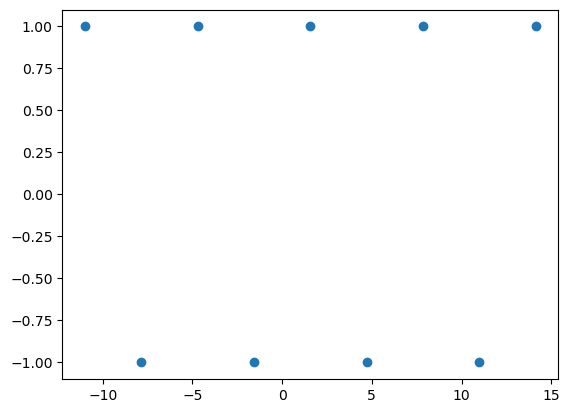

In [11]:
input_pattern = "linear shifted"
num_points = 9 
START = -4*np.pi
END = 4*np.pi
noise_x = 0.0
input_target_dim = 0
noise_y = 0.0
output_target_dim = 0
output_dim = 1
output_pattern = lambda x: torch.sin(x) + noise_y
data_generator = data_functions.DataGenerator()
train_x = data_generator.generate_inputs(input_pattern, n_points=num_points, START=START, END=END, SHIFT=np.pi/2, NOISE=noise_x, target_dim=input_target_dim)
train_y = data_generator.generate_labels(train_x, output_pattern, n_dim=output_dim, target_dim=output_target_dim)
plt.plot(train_x, train_y, "o")

In [10]:
def option_product(options):
    product = [x for x in itertools.product(*options.values())]
    return [dict(zip(options.keys(), p)) for p in product]

In [15]:
# Loop settings
# I want to iterate over the product of dataset size and noise
# I will vary the kernel between "SE" and "SE+SE"


kernel_list = ["SE", "SE+SE", "PER", "C*PER", "C*SE", "MAT32"]

logarithmic_reinit=True
levels = [1e+5]
uninformed = True

# Optional input arguments
input_dim = 1 # usually datasets_1d[XYZ].path 
input_target_dim = 0

output_dim = 1 # usually datasets_1d[XYZ].path
output_target_dim = 1

results_table_list = list()

START = [-4*np.pi]
END = [4*np.pi]
num_point_list = [17] #n*8+1
input_patterns = [("linear shifted", "linear shifted")]
noise_list_y = [0.0, 0.1, 0.2, 0.3, 0.4]
#noise_list_x = [0.0, 0.1, 0.2, 0.3, 0.4]
noise_list_x = [0.0, 0.1, 0.2]
data_norm_x = [False]
data_norm_y = [True] 


options = {"num_points": num_point_list,
           "noise_x": noise_list_x,
           "noise_y": noise_list_y}
data_settings = option_product(options)
print(data_settings)

results_table_dict = dict()

for data_setting in data_settings:
    #START = data_setting["START"]
    #END = data_setting["END"]
    START = -4*np.pi
    END = 4*np.pi
    #output_pattern = data_setting["output_pattern"]
    #output_pattern_str = data_setting["output_pattern_str"]
    #input_pattern = data_setting["input_pattern"]
    #input_pattern_str = data_setting["input_pattern_str"]
    input_pattern = "linear shifted"
    input_pattern_str = "linear shifted"
    #input_dim = data_setting["input_dim"]
    #input_target_dim = data_setting["input_target_dim"]
    #output_dim = data_setting["output_dim"]
    #output_target_dim = data_setting["output_target_dim"]
    num_points = data_setting["num_points"]
    noise_x = data_setting["noise_x"]
    noise_y = data_setting["noise_y"]
    #data_norm_x = data_setting["data_norm_x"]
    #data_norm_y = data_setting["data_norm_y"]
    data_norm_x = False
    data_norm_y = True 


    for kernel_name in kernel_list:
        output_pattern = lambda x: torch.sin(x) + noise_y
        output_pattern_str = f"sin(x) + {noise_y}"
        print(f"num_points: {num_points}, noise x-y: {noise_x}-{noise_y}, kernel_name: {kernel_name}")
        # Generate the data
        data_generator = data_functions.DataGenerator()
        train_x = data_generator.generate_inputs(input_pattern, n_points=num_points, START=START, END=END, SHIFT=np.pi/2, NOISE=noise_x, target_dim=input_target_dim)
        train_y = data_generator.generate_labels(train_x, output_pattern, n_dim=output_dim, target_dim=output_target_dim)

        # Normalize the data
        if data_norm_x:
            train_x = data_functions.Transformations.z_score(train_x)
        if data_norm_y:
            train_y = data_functions.Transformations.z_score(train_y)

        ## Define the GP model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(train_x, train_y, likelihood, kernel_text=kernel_name)
        likelihood_MAP = gpytorch.likelihoods.GaussianLikelihood()
        model_MAP = ExactGPModel(train_x, train_y, likelihood_MAP, kernel_text=kernel_name)


        random_restarts = 4

        ## Train the GPs
        model.train()
        likelihood.train()
        neg_scaled_mll_loss, model, likelihood, mll_train_log = optimize_hyperparameters(model, likelihood, X=train_x, Y=train_y, MAP=False, uninformed=uninformed, random_restarts=random_restarts, verbose=False)


        model_MAP.train()
        likelihood_MAP.train()
        neg_scaled_map_loss, model_MAP, likelihood_MAP, map_train_log = optimize_hyperparameters(model_MAP, likelihood_MAP, X=train_x, Y=train_y, MAP=True, uninformed=uninformed, random_restarts=random_restarts, verbose=False)

        pos_unscaled_MLL = -neg_scaled_mll_loss*len(*model.train_inputs)
        pos_unscaled_MAP = -neg_scaled_map_loss*len(*model.train_inputs)
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        bool_use_finite_difference_hessian = True

        ## Calculate the metrics
        AIC_val, AIC_logs = AIC(pos_unscaled_MLL, num_params)
        BIC_val, BIC_logs = BIC(pos_unscaled_MLL, num_params, torch.tensor(len(train_x)))
        AIC_MAP_val, AIC_MAP_logs = AIC(pos_unscaled_MAP, num_params)
        BIC_MAP_val, BIC_MAP_logs = BIC(pos_unscaled_MAP, num_params, torch.tensor(len(train_x)))
        Lap0_val, Lap0_logs =     Laplace(model_MAP, pos_unscaled_MAP.clone(), uninformed=uninformed, use_finite_difference_hessian=bool_use_finite_difference_hessian, param_punish_term=0)
        LapAIC_val, LapAIC_logs = Laplace(model_MAP, pos_unscaled_MAP.clone(), uninformed=uninformed, use_finite_difference_hessian=bool_use_finite_difference_hessian, param_punish_term=-1)
        LapBIC_val, LapBIC_logs = Laplace(model_MAP, pos_unscaled_MAP.clone(), uninformed=uninformed, use_finite_difference_hessian=bool_use_finite_difference_hessian, param_punish_term="BIC")

        maxcall = 1e+5
        nested_pos_model_evidence_e5, Nested_logs_e5 = Nested(model, store_full=False, maxcall=maxcall, uninformed=uninformed)

        if num_points in results_table_dict.keys():
            # If the num_points already exists, append the new kernel and its values
            results_table_dict[num_points][kernel_name] = {
                "MLL": pos_unscaled_MLL,
                "AIC (s)": -0.5*AIC_val,
                "BIC (s)": -0.5*BIC_val,
                "MAP": pos_unscaled_MAP,
                "Lap0": Lap0_val,
                "LapAIC": LapAIC_val,
                "LapBIC": LapBIC_val,
                "Nested (1e+5)": nested_pos_model_evidence_e5
            }
        else:
            # If the num_points doesn't exist, create a new entry
            results_table_dict[num_points] = {}
            # Add the kernel and its values
            results_table_dict[num_points][kernel_name] = {
                "MLL": pos_unscaled_MLL,
                "AIC (s)": -0.5*AIC_val,
                "BIC (s)": -0.5*BIC_val,
                "MAP": pos_unscaled_MAP,
                "Lap0": Lap0_val,
                "LapAIC": LapAIC_val,
                "LapBIC": LapBIC_val,
                "Nested (1e+5)": nested_pos_model_evidence_e5
            }

        result_table = f"| {num_points:<10} | {noise_x:<5} | {noise_y:<5}| {kernel_name:<6} | {pos_unscaled_MLL:.3f} | {-0.5*AIC_val:.3f} | {-0.5*BIC_val:.3f} | {pos_unscaled_MAP:.3f} | {Lap0_val:.3f} | {LapAIC_val:.3f} | {LapBIC_val:.3f} | {nested_pos_model_evidence_e5:.3f} |"

        results_table_list.append(result_table)
        print(result_table)


[{'num_points': 17, 'noise_x': 0.0, 'noise_y': 0.0}, {'num_points': 17, 'noise_x': 0.0, 'noise_y': 0.1}, {'num_points': 17, 'noise_x': 0.0, 'noise_y': 0.2}, {'num_points': 17, 'noise_x': 0.0, 'noise_y': 0.3}, {'num_points': 17, 'noise_x': 0.0, 'noise_y': 0.4}, {'num_points': 17, 'noise_x': 0.1, 'noise_y': 0.0}, {'num_points': 17, 'noise_x': 0.1, 'noise_y': 0.1}, {'num_points': 17, 'noise_x': 0.1, 'noise_y': 0.2}, {'num_points': 17, 'noise_x': 0.1, 'noise_y': 0.3}, {'num_points': 17, 'noise_x': 0.1, 'noise_y': 0.4}, {'num_points': 17, 'noise_x': 0.2, 'noise_y': 0.0}, {'num_points': 17, 'noise_x': 0.2, 'noise_y': 0.1}, {'num_points': 17, 'noise_x': 0.2, 'noise_y': 0.2}, {'num_points': 17, 'noise_x': 0.2, 'noise_y': 0.3}, {'num_points': 17, 'noise_x': 0.2, 'noise_y': 0.4}]
num_points: 17, noise x-y: 0.0-0.0, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 964676


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.0  | SE     | -20.758 | -22.758 | -23.591 | -27.489 | -27.914 | -29.489 | -30.322 | -24.393 |
num_points: 17, noise x-y: 0.0-0.0, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 653292


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.0   | 0.0  | SE+SE  | -19.195 | -22.195 | -23.445 | -29.259 | -30.078 | -32.259 | -33.509 | -25.905 |
num_points: 17, noise x-y: 0.0-0.0, kernel_name: PER
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.05
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.05
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.05
Random seed: 979534


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage

| 17         | 0.0   | 0.0  | PER    | 39.572 | 36.572 | 35.322 | 28.853 | 21.799 | 19.799 | 18.966 | 28.332 |
num_points: 17, noise x-y: 0.0-0.0, kernel_name: C*PER


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 238300


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.0   | 0.0  | C*PER  | 39.575 | 35.575 | 33.908 | 25.490 | 22.184 | 19.184 | 17.935 | 24.490 |
num_points: 17, noise x-y: 0.0-0.0, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 418331


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.0  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.917 | -32.055 | -33.305 | -25.193 |
num_points: 17, noise x-y: 0.0-0.0, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 854350


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.0  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.959 |
num_points: 17, noise x-y: 0.0-0.1, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 314089


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.1  | SE     | -20.759 | -22.759 | -23.592 | -27.489 | -27.913 | -29.489 | -30.322 | -24.483 |
num_points: 17, noise x-y: 0.0-0.1, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 914321


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.0   | 0.1  | SE+SE  | -19.196 | -22.196 | -23.445 | -29.259 | -30.077 | -32.259 | -33.509 | -25.969 |
num_points: 17, noise x-y: 0.0-0.1, kernel_name: PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 999463


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.0   | 0.1  | PER    | 39.577 | 36.577 | 35.327 | 28.853 | 21.808 | 19.808 | 18.975 | 27.264 |
num_points: 17, noise x-y: 0.0-0.1, kernel_name: C*PER


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 405058


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.0   | 0.1  | C*PER  | 39.575 | 35.575 | 33.909 | 25.493 | 22.189 | 19.189 | 17.939 | 26.820 |
num_points: 17, noise x-y: 0.0-0.1, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 696070


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.0   | 0.1  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.916 | -32.055 | -33.305 | -25.361 |
num_points: 17, noise x-y: 0.0-0.1, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 932004


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.1  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.888 |
num_points: 17, noise x-y: 0.0-0.2, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 788788


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.2  | SE     | -20.759 | -22.759 | -23.592 | -27.489 | -27.914 | -29.489 | -30.322 | -24.500 |
num_points: 17, noise x-y: 0.0-0.2, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 981248


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.0   | 0.2  | SE+SE  | -19.197 | -22.197 | -23.447 | -29.259 | -30.078 | -32.259 | -33.509 | -25.889 |
num_points: 17, noise x-y: 0.0-0.2, kernel_name: PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 121959


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.0   | 0.2  | PER    | 39.576 | 36.576 | 35.326 | 28.725 | 25.226 | 23.226 | 22.393 | 27.033 |
num_points: 17, noise x-y: 0.0-0.2, kernel_name: C*PER


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 580121


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.0   | 0.2  | C*PER  | 39.562 | 35.562 | 33.896 | 25.492 | 22.187 | 19.187 | 17.937 | 27.179 |
num_points: 17, noise x-y: 0.0-0.2, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 925187


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.0   | 0.2  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.916 | -32.055 | -33.305 | -25.294 |
num_points: 17, noise x-y: 0.0-0.2, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 57801


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.2  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.888 |
num_points: 17, noise x-y: 0.0-0.3, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 301819


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.3  | SE     | -20.758 | -22.758 | -23.591 | -27.489 | -27.915 | -29.489 | -30.322 | -24.419 |
num_points: 17, noise x-y: 0.0-0.3, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 143524


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.0   | 0.3  | SE+SE  | -19.195 | -22.195 | -23.445 | -29.259 | -30.077 | -32.259 | -33.509 | -25.950 |
num_points: 17, noise x-y: 0.0-0.3, kernel_name: PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 661018


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.0   | 0.3  | PER    | 39.576 | 36.576 | 35.326 | 28.724 | 25.226 | 23.226 | 22.393 | 27.926 |
num_points: 17, noise x-y: 0.0-0.3, kernel_name: C*PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 947260


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.0   | 0.3  | C*PER  | 39.563 | 35.563 | 33.896 | 25.502 | 22.186 | 19.186 | 17.936 | 24.472 |
num_points: 17, noise x-y: 0.0-0.3, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 984267


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.0   | 0.3  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.916 | -32.055 | -33.305 | -25.183 |
num_points: 17, noise x-y: 0.0-0.3, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 790880


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.3  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.915 |
num_points: 17, noise x-y: 0.0-0.4, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 982507


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.4  | SE     | -20.758 | -22.758 | -23.592 | -27.489 | -27.913 | -29.489 | -30.322 | -24.446 |
num_points: 17, noise x-y: 0.0-0.4, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 774086


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.0   | 0.4  | SE+SE  | -19.195 | -22.195 | -23.445 | -29.259 | -30.078 | -32.259 | -33.509 | -25.891 |
num_points: 17, noise x-y: 0.0-0.4, kernel_name: PER


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 681251


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.0   | 0.4  | PER    | 39.565 | 36.565 | 35.315 | 28.726 | 25.228 | 23.228 | 22.395 | 27.259 |
num_points: 17, noise x-y: 0.0-0.4, kernel_name: C*PER


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 448189


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.0   | 0.4  | C*PER  | 39.577 | 35.577 | 33.911 | 25.491 | 22.185 | 19.185 | 17.936 | 27.492 |
num_points: 17, noise x-y: 0.0-0.4, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 835845


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.4  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.917 | -32.055 | -33.305 | -25.234 |
num_points: 17, noise x-y: 0.0-0.4, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 360378


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.0   | 0.4  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.891 |
num_points: 17, noise x-y: 0.1-0.0, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 925635


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.1   | 0.0  | SE     | -20.758 | -22.758 | -23.592 | -27.489 | -27.914 | -29.489 | -30.322 | -24.514 |
num_points: 17, noise x-y: 0.1-0.0, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 27199


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.1   | 0.0  | SE+SE  | -19.195 | -22.195 | -23.445 | -29.259 | -30.078 | -32.259 | -33.509 | -25.938 |
num_points: 17, noise x-y: 0.1-0.0, kernel_name: PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 897653


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.1   | 0.0  | PER    | 39.564 | 36.564 | 35.314 | 28.726 | 25.229 | 23.229 | 22.396 | 27.129 |
num_points: 17, noise x-y: 0.1-0.0, kernel_name: C*PER
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 146625


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.1   | 0.0  | C*PER  | 39.581 | 35.581 | 33.914 | 25.494 | 21.849 | 18.849 | 17.600 | 24.972 |
num_points: 17, noise x-y: 0.1-0.0, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 281026


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.1   | 0.0  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.917 | -32.055 | -33.305 | -25.188 |
num_points: 17, noise x-y: 0.1-0.0, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 248231


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.1   | 0.0  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.921 |
num_points: 17, noise x-y: 0.1-0.1, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 262834


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.1   | 0.1  | SE     | -20.758 | -22.758 | -23.592 | -27.489 | -27.915 | -29.489 | -30.322 | -24.374 |
num_points: 17, noise x-y: 0.1-0.1, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 139673


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.1   | 0.1  | SE+SE  | -19.196 | -22.196 | -23.445 | -29.259 | -30.078 | -32.259 | -33.509 | -25.994 |
num_points: 17, noise x-y: 0.1-0.1, kernel_name: PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 479806


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.1   | 0.1  | PER    | 39.565 | 36.565 | 35.315 | 28.726 | 25.227 | 23.227 | 22.393 | 27.011 |
num_points: 17, noise x-y: 0.1-0.1, kernel_name: C*PER


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 879643


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.1   | 0.1  | C*PER  | 39.590 | 35.590 | 33.923 | 25.679 | 18.980 | 15.980 | 14.730 | 23.328 |
num_points: 17, noise x-y: 0.1-0.1, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 87237


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.1   | 0.1  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.918 | -32.055 | -33.305 | -25.190 |
num_points: 17, noise x-y: 0.1-0.1, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 750916


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.1   | 0.1  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.909 |
num_points: 17, noise x-y: 0.1-0.2, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 693706


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.1   | 0.2  | SE     | -20.757 | -22.757 | -23.590 | -27.489 | -27.914 | -29.489 | -30.322 | -24.458 |
num_points: 17, noise x-y: 0.1-0.2, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 105716


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.1   | 0.2  | SE+SE  | -19.195 | -22.195 | -23.445 | -29.259 | -30.077 | -32.259 | -33.509 | -25.961 |
num_points: 17, noise x-y: 0.1-0.2, kernel_name: PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 817450


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.1   | 0.2  | PER    | 39.565 | 36.565 | 35.315 | 28.727 | 25.314 | 23.314 | 22.481 | 27.400 |
num_points: 17, noise x-y: 0.1-0.2, kernel_name: C*PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 415391


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.1   | 0.2  | C*PER  | 39.578 | 35.578 | 33.912 | 25.492 | 22.187 | 19.187 | 17.937 | 26.353 |
num_points: 17, noise x-y: 0.1-0.2, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 764176


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.1   | 0.2  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.918 | -32.055 | -33.305 | -25.279 |
num_points: 17, noise x-y: 0.1-0.2, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 469918


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.1   | 0.2  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.931 |
num_points: 17, noise x-y: 0.1-0.3, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 264793


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.1   | 0.3  | SE     | -20.759 | -22.759 | -23.592 | -27.489 | -27.913 | -29.489 | -30.322 | -24.443 |
num_points: 17, noise x-y: 0.1-0.3, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 800551


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.1   | 0.3  | SE+SE  | -19.195 | -22.195 | -23.444 | -29.259 | -30.078 | -32.259 | -33.509 | -25.853 |
num_points: 17, noise x-y: 0.1-0.3, kernel_name: PER
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 243539


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.1   | 0.3  | PER    | 39.575 | 36.575 | 35.325 | 28.729 | 25.322 | 23.322 | 22.488 | 27.320 |
num_points: 17, noise x-y: 0.1-0.3, kernel_name: C*PER
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 72140


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.1   | 0.3  | C*PER  | 39.563 | 35.563 | 33.896 | 25.494 | 22.189 | 19.189 | 17.939 | 27.218 |
num_points: 17, noise x-y: 0.1-0.3, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 151031


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.1   | 0.3  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.916 | -32.055 | -33.305 | -25.322 |
num_points: 17, noise x-y: 0.1-0.3, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 802834


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.1   | 0.3  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.945 |
num_points: 17, noise x-y: 0.1-0.4, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 317693


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.1   | 0.4  | SE     | -20.758 | -22.758 | -23.591 | -27.489 | -27.913 | -29.489 | -30.322 | -24.406 |
num_points: 17, noise x-y: 0.1-0.4, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 412637


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.1   | 0.4  | SE+SE  | -19.195 | -22.195 | -23.445 | -29.259 | -30.078 | -32.259 | -33.509 | -26.053 |
num_points: 17, noise x-y: 0.1-0.4, kernel_name: PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 840891


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.1   | 0.4  | PER    | 39.565 | 36.565 | 35.315 | 28.728 | 25.315 | 23.315 | 22.482 | 27.655 |
num_points: 17, noise x-y: 0.1-0.4, kernel_name: C*PER
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.05
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.025
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.0125
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.00625
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.003125
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.0015625
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.00078125
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.000390625
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.0001953125
Negative diagonal entry in Hessian. Running with smaller ste

/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage

| 17         | 0.1   | 0.4  | C*PER  | 39.589 | 35.589 | 33.923 | 25.497 | 22.016 | 19.016 | 17.767 | 27.603 |
num_points: 17, noise x-y: 0.1-0.4, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 677842


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.1   | 0.4  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.916 | -32.055 | -33.305 | -25.197 |
num_points: 17, noise x-y: 0.1-0.4, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 129456


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.1   | 0.4  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.872 |
num_points: 17, noise x-y: 0.2-0.0, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 328981


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.2   | 0.0  | SE     | -20.759 | -22.759 | -23.592 | -27.489 | -27.914 | -29.489 | -30.322 | -24.391 |
num_points: 17, noise x-y: 0.2-0.0, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 506071


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.2   | 0.0  | SE+SE  | -19.195 | -22.195 | -23.445 | -29.259 | -30.078 | -32.259 | -33.509 | -25.968 |
num_points: 17, noise x-y: 0.2-0.0, kernel_name: PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 505014


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.2   | 0.0  | PER    | 39.565 | 36.565 | 35.316 | 28.726 | 25.229 | 23.229 | 22.396 | 26.315 |
num_points: 17, noise x-y: 0.2-0.0, kernel_name: C*PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 89385


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.2   | 0.0  | C*PER  | 39.575 | 35.575 | 33.908 | 25.490 | 22.184 | 19.184 | 17.935 | 27.037 |
num_points: 17, noise x-y: 0.2-0.0, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 506017


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(


| 17         | 0.2   | 0.0  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.916 | -32.055 | -33.305 | -25.350 |
num_points: 17, noise x-y: 0.2-0.0, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 456960


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.2   | 0.0  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.949 |
num_points: 17, noise x-y: 0.2-0.1, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 609293


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.2   | 0.1  | SE     | -20.758 | -22.758 | -23.591 | -27.489 | -27.915 | -29.489 | -30.322 | -24.516 |
num_points: 17, noise x-y: 0.2-0.1, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 63176


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(


| 17         | 0.2   | 0.1  | SE+SE  | -19.194 | -22.194 | -23.444 | -29.259 | -30.078 | -32.259 | -33.509 | -25.956 |
num_points: 17, noise x-y: 0.2-0.1, kernel_name: PER


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 51471


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.2   | 0.1  | PER    | 39.577 | 36.577 | 35.327 | 28.728 | 25.352 | 23.352 | 22.519 | 26.845 |
num_points: 17, noise x-y: 0.2-0.1, kernel_name: C*PER


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 760979


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.2   | 0.1  | C*PER  | 39.590 | 35.590 | 33.924 | 25.493 | 22.189 | 19.189 | 17.939 | 26.034 |
num_points: 17, noise x-y: 0.2-0.1, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 635494


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.2   | 0.1  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.916 | -32.055 | -33.305 | -25.360 |
num_points: 17, noise x-y: 0.2-0.1, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 687914


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.2   | 0.1  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.905 |
num_points: 17, noise x-y: 0.2-0.2, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 587898


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.2   | 0.2  | SE     | -20.758 | -22.758 | -23.591 | -27.489 | -27.913 | -29.489 | -30.322 | -24.346 |
num_points: 17, noise x-y: 0.2-0.2, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 333074


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.2   | 0.2  | SE+SE  | -19.195 | -22.195 | -23.445 | -29.259 | -30.078 | -32.259 | -33.509 | -26.016 |
num_points: 17, noise x-y: 0.2-0.2, kernel_name: PER
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss i

/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 546197


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.2   | 0.2  | PER    | 39.565 | 36.565 | 35.315 | 28.725 | 25.226 | 23.226 | 22.393 | 27.976 |
num_points: 17, noise x-y: 0.2-0.2, kernel_name: C*PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 465992


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.2   | 0.2  | C*PER  | 39.562 | 35.562 | 33.896 | 25.505 | 22.153 | 19.153 | 17.903 | 25.330 |
num_points: 17, noise x-y: 0.2-0.2, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 715275


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.2   | 0.2  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.918 | -32.055 | -33.305 | -25.261 |
num_points: 17, noise x-y: 0.2-0.2, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 592652


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.2   | 0.2  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.848 |
num_points: 17, noise x-y: 0.2-0.3, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 99303


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.2   | 0.3  | SE     | -20.758 | -22.758 | -23.591 | -27.489 | -27.913 | -29.489 | -30.322 | -24.456 |
num_points: 17, noise x-y: 0.2-0.3, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 816064


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(


| 17         | 0.2   | 0.3  | SE+SE  | -19.195 | -22.195 | -23.445 | -29.259 | -30.079 | -32.259 | -33.509 | -25.951 |
num_points: 17, noise x-y: 0.2-0.3, kernel_name: PER


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Random seed: 517156


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.2   | 0.3  | PER    | 39.575 | 36.575 | 35.325 | 28.724 | 25.226 | 23.226 | 22.393 | 28.509 |
num_points: 17, noise x-y: 0.2-0.3, kernel_name: C*PER


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.05
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.025
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.0125
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.00625
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.003125
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.0015625
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.00078125
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.000390625
Negative diagonal entry in Hessian. Running with smaller step
New precision: 0.0001953125
Negative diagonal entry in Hessian. Running with smaller step
New precision: 9.765

/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage

| 17         | 0.2   | 0.3  | C*PER  | 39.579 | 35.579 | 33.913 | 25.640 | 18.558 | 15.558 | 14.309 | 27.353 |
num_points: 17, noise x-y: 0.2-0.3, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 734100


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.2   | 0.3  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.918 | -32.055 | -33.305 | -25.253 |
num_points: 17, noise x-y: 0.2-0.3, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 173527


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.2   | 0.3  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.964 |
num_points: 17, noise x-y: 0.2-0.4, kernel_name: SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 864661


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.2   | 0.4  | SE     | -20.758 | -22.758 | -23.591 | -27.489 | -27.913 | -29.489 | -30.322 | -24.436 |
num_points: 17, noise x-y: 0.2-0.4, kernel_name: SE+SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 913563


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(


| 17         | 0.2   | 0.4  | SE+SE  | -19.195 | -22.195 | -23.445 | -29.259 | -30.078 | -32.259 | -33.509 | -25.947 |
num_points: 17, noise x-y: 0.2-0.4, kernel_name: PER
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 463035


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.2   | 0.4  | PER    | 39.565 | 36.565 | 35.315 | 28.726 | 25.228 | 23.228 | 22.395 | 27.805 |
num_points: 17, noise x-y: 0.2-0.4, kernel_name: C*PER


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Severe PyGRANSO issue. Loss i

/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 534738


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/

| 17         | 0.2   | 0.4  | C*PER  | 39.586 | 35.586 | 33.920 | 25.500 | 22.075 | 19.075 | 17.826 | 26.497 |
num_points: 17, noise x-y: 0.2-0.4, kernel_name: C*SE


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 244432


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very compl

| 17         | 0.2   | 0.4  | C*SE   | -18.899 | -21.899 | -23.149 | -29.055 | -29.917 | -32.055 | -33.305 | -25.308 |
num_points: 17, noise x-y: 0.2-0.4, kernel_name: MAT32


/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for val in vals], dtype=vals.dtype))


Random seed: 863616


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/dynesty/dynamicsampler.py:453: RuntimeWarning: overflow encountered in cast
  cur_live_logl[not_finite] = _LOWL_VAL


| 17         | 0.2   | 0.4  | MAT32  | -23.515 | -25.515 | -26.348 | -30.046 | -30.046 | -32.046 | -32.879 | -24.940 |


---

In [13]:
print(f"| datapoints | noise x | noise y | kernel | MLL | AIC (s) | BIC (s) | MAP | Lap0 | LapAIC | LapBIC | Nested (1e+5) |")
print(f"|------------|-------|-------|--------|-----|-----|-----|-----|------|--------|--------|-----------------|")
for row in results_table_list:
    print(row)


| datapoints | noise x | noise y | kernel | MLL | AIC (s) | BIC (s) | MAP | Lap0 | LapAIC | LapBIC | Nested (1e+5) |
|------------|-------|-------|--------|-----|-----|-----|-----|------|--------|--------|-----------------|
| 9          | 0.3   | 0.0  | SE     | -12.271 | -14.271 | -14.468 | -18.787 | -18.787 | -20.787 | -20.984 | -13.526 |
| 9          | 0.3   | 0.0  | SE+SE  | -13.390 | -16.390 | -16.686 | -23.153 | -23.153 | -26.153 | -26.449 | -14.691 |
| 9          | 0.3   | 0.0  | PER    | 21.554 | 18.554 | 18.259 | 10.930 | 7.108 | 5.108 | 4.911 | 11.453 |
| 9          | 0.3   | 0.0  | C*PER  | 21.560 | 17.560 | 17.166 | 7.736 | 3.285 | 0.285 | -0.011 | 10.014 |
| 9          | 0.3   | 0.0  | C*SE   | -12.240 | -15.240 | -15.536 | -21.908 | -21.908 | -24.908 | -25.204 | -14.938 |
| 9          | 0.3   | 0.0  | MAT32  | -12.271 | -14.271 | -14.468 | -18.789 | -18.789 | -20.789 | -20.986 | -13.487 |
| 9          | 0.3   | 0.1  | SE     | -12.271 | -14.271 | -14.468 | -18.787 | -18.7

In [ ]:
results_table_string = """
| datapoints | noise | kernel | MLL | AIC (s) | BIC (s) | MAP | Lap0 | LapAIC | LapBIC | Nested (1e+5) |
|------------|-------|--------|-----|-----|-----|-----|------|--------|--------|-----------------|
| 11         | 0.0   | SE     | -1.981 | -3.981 | -4.379 | -9.095 | -9.795 | -11.095 | -11.493 | -7.715 |
| 11         | 0.0   | SE+SE  | -1.130 | -4.130 | -4.727 | -11.524 | -12.200 | -14.524 | -15.121 | -8.206 |
| 11         | 0.0   | PER    | -2.132 | -5.132 | -5.728 | 1.379 | -2.444 | -4.444 | -4.842 | 1.887 |
| 11         | 0.0   | C*SE   | -0.914 | -3.914 | -4.511 | -11.387 | -12.124 | -14.387 | -14.984 | -7.431 |
| 11         | 0.0   | LIN    | -15.035 | -17.035 | -17.433 | -21.611 | -21.611 | -23.611 | -24.009 | -18.426 |
| 11         | 0.0   | LIN*SE | 3.632 | 0.632 | 0.035 | -6.883 | -7.389 | -9.883 | -10.480 | -3.859 |
| 11         | 0.0   | LIN*PER | 2.810 | -1.190 | -1.985 | -2.838 | -6.091 | -9.091 | -9.688 | 0.360 |
| 11         | 0.0   | MAT32  | -9.851 | -11.851 | -12.249 | -16.584 | -16.584 | -18.584 | -18.982 | -13.671 |
| 21         | 0.0   | SE     | 30.451 | 28.451 | 27.407 | 23.042 | 22.184 | 21.042 | 19.997 | 24.227 |
| 21         | 0.0   | SE+SE  | 31.798 | 28.798 | 27.232 | 21.136 | 20.287 | 18.136 | 16.569 | 23.675 |
| 21         | 0.0   | PER    | 46.136 | 43.136 | 41.569 | 35.061 | 30.846 | 28.846 | 27.801 | 35.145 |
| 21         | 0.0   | C*SE   | 32.593 | 29.593 | 28.027 | 21.771 | 20.956 | 18.771 | 17.205 | 25.639 |
| 21         | 0.0   | LIN    | -29.134 | -31.134 | -32.179 | -35.710 | -35.710 | -37.710 | -38.754 | -33.084 |
| 21         | 0.0   | LIN*SE | 37.590 | 34.590 | 33.024 | 26.914 | 26.203 | 23.914 | 22.347 | 29.736 |
| 21         | 0.0   | LIN*PER | 36.764 | 32.764 | 30.675 | 29.592 | 26.197 | 23.197 | 21.630 | 31.478 |
| 21         | 0.0   | MAT32  | 3.527 | 1.527 | 0.482 | -3.532 | -3.532 | -5.532 | -6.577 | -1.249 |
| 31         | 0.0   | SE     | 65.145 | 63.145 | 61.711 | 57.641 | 56.741 | 55.641 | 54.207 | 58.783 |
| 31         | 0.0   | SE+SE  | 66.686 | 63.686 | 61.535 | 55.920 | 54.964 | 52.920 | 50.769 | 58.198 |
| 31         | 0.0   | PER    | 81.413 | 78.413 | 76.262 | 70.253 | 65.827 | 63.827 | 62.393 | 69.056 |
| 31         | 0.0   | C*SE   | 67.707 | 64.707 | 62.556 | 56.762 | 55.974 | 53.762 | 51.611 | 60.527 |
| 31         | 0.0   | LIN    | -43.187 | -45.187 | -46.621 | -49.762 | -49.777 | -51.762 | -53.196 | -47.408 |
| 31         | 0.0   | LIN*SE | 72.926 | 69.926 | 67.775 | 62.166 | 61.412 | 59.166 | 57.015 | 65.192 |
| 31         | 0.0   | LIN*PER | 78.119 | 74.119 | 71.251 | 56.785 | 55.809 | 52.785 | 49.917 | 66.687 |
| 31         | 0.0   | MAT32  | 27.386 | 25.386 | 23.952 | 20.107 | 20.014 | 18.107 | 16.673 | 22.286 |
| 51         | 0.0   | SE     | 136.141 | 134.141 | 132.209 | 128.537 | 127.592 | 126.537 | 124.605 | 129.762 |
| 51         | 0.0   | SE+SE  | 137.842 | 134.842 | 131.945 | 127.051 | 125.992 | 124.051 | 121.153 | 129.198 |
| 51         | 0.0   | PER    | 153.141 | 150.141 | 147.243 | 141.886 | 137.198 | 135.198 | 133.267 | 139.915 |
| 51         | 0.0   | C*SE   | 139.179 | 136.179 | 133.282 | 128.056 | 127.158 | 125.056 | 122.158 | 131.829 |
| 51         | 0.0   | LIN    | -71.224 | -73.224 | -75.156 | -77.798 | -78.061 | -79.798 | -81.730 | -75.861 |
| 51         | 0.0   | LIN*SE | 144.777 | 141.777 | 138.880 | 133.833 | 132.981 | 130.833 | 127.935 | 136.811 |
| 51         | 0.0   | LIN*PER | 58.996 | 54.996 | 51.132 | -64.149 | -66.169 | -68.677 | -72.013 | 137.058 |
| 51         | 0.0   | MAT32  | 87.749 | 85.749 | 83.817 | 80.242 | 79.982 | 78.242 | 76.311 | 82.258 |
| 91         | 0.0   | SE     | 280.363 | 278.363 | 275.852 | 272.668 | 271.787 | 270.668 | 268.157 | 273.819 |
| 91         | 0.0   | SE+SE  | 282.393 | 279.393 | 275.626 | 271.424 | 270.035 | 268.424 | 264.658 | 273.296 |
| 91         | 0.0   | PER    | 279.154 | 276.154 | 272.387 | 286.779 | 281.792 | 279.792 | 277.281 | 285.141 |
| 91         | 0.0   | C*SE   | 283.812 | 280.812 | 277.046 | 272.768 | 271.344 | 269.768 | 266.002 | 276.436 |
| 91         | 0.0   | LIN    | -127.167 | -129.167 | -131.678 | -133.740 | -134.292 | -135.740 | -138.251 | -132.188 |
| 91         | 0.0   | LIN*SE | 289.852 | 286.852 | 283.086 | 278.777 | 278.110 | 275.777 | 272.011 | 282.236 |
| 91         | 0.0   | LIN*PER | 290.117 | 286.117 | 281.095 | 270.601 | 269.957 | 266.601 | 261.579 | 281.983 |
| 91         | 0.0   | MAT32  | 221.876 | 219.876 | 217.366 | 214.193 | 213.807 | 212.193 | 209.683 | 215.820 |"""


# Filter out the first two lines
results_table_string = results_table_string.split("\n")[3:]
results_table_dict = {}
for row in results_table_string:
    # Split the row by "|"
    parts = row.split("|")
    # Extract the values
    num_points = int(parts[1].strip())
    noise = float(parts[2].strip())
    kernel = parts[3].strip()
    mll = float(parts[4].strip())
    aic = float(parts[5].strip())
    bic = float(parts[6].strip())
    map_val = float(parts[7].strip())
    lap0 = float(parts[8].strip())
    lap_aic = float(parts[9].strip())
    lap_bic = float(parts[10].strip())
    nested = float(parts[11].strip())

    if num_points in results_table_dict.keys():
        # If the num_points already exists, append the new kernel and its values
        results_table_dict[num_points][kernel] = {
            "MLL": mll,
            "AIC (s)": aic,
            "BIC (s)": bic,
            "MAP": map_val,
            "Lap0": lap0,
            "LapAIC": lap_aic,
            "LapBIC": lap_bic,
            "Nested (1e+5)": nested
        }
    else:
        # If the num_points doesn't exist, create a new entry
        results_table_dict[num_points] = {}
        # Add the kernel and its values
        results_table_dict[num_points][kernel] = {
            "MLL": mll,
            "AIC (s)": aic,
            "BIC (s)": bic,
            "MAP": map_val,
            "Lap0": lap0,
            "LapAIC": lap_aic,
            "LapBIC": lap_bic,
            "Nested (1e+5)": nested
        }

In [ ]:
for target_size in [11, 21, 31, 51, 91]:
    print(f"Results for target size {target_size}:")
    #for key in ["MLL", "AIC (s)", "BIC (s)", "MAP", "Lap0", "LapAIC", "LapBIC", "Nested (1e+5)"]:
    for key in ["AIC (s)", "Lap0", "Nested (1e+5)"]:
        print(key)
        sorted_results_table_dict = sorted(results_table_dict[target_size], key=lambda x: results_table_dict[target_size][x][key], reverse=True)
        for kernel in sorted_results_table_dict:
            print(f"{kernel}:\t\t {results_table_dict[target_size][kernel][key]}")
        print()
    print()

## 2D data

In [ ]:
possible_X_patterns = [
    "away",
    "bullseye",
    "circle",
    "dots",
    "dots minimal",
    "dots minimal no shift",
    "dots minimal shifted",
    "dots minimal shifted around zero",
    "dots minimal shifted to zero",
    "dots favouring lower values",
    "line",
    "line X",
    "line 05X1Y",
    "h_lines",
    "high lines",
    "slant down",
    "slant up",
    "star",
    "v_lines",
    "wide lines",
    "x_shape",
]

possible_kenels = [
        "[SE; SE]", #0
        "[SE; LIN]",
        "[LIN; SE]",
        "[LIN; LIN]", #3
        "[LIN;* LIN]",
        "[SE;* 1]", #5
        "[PER;* 1]", #6
        "[SE+SE; 1]", #7 
        "[SE+SE; 1]2" #8 #BOO. Fuck not using AdditiveStructureKernels. All my Homies love AdditiveStructureKernels
    ]


In [ ]:
datasets_2d.keys()

In [ ]:
data_functions.list_available_patterns()

In [ ]:
kernel_name = possible_kenels[6]


input_pattern_str = "wide lines"
input_pattern = datasets_2d[input_pattern_str].path  # usually some datasets_2d[XYZ].path
input_dim = 2 # datasets_2d[XYZ].dimension
input_target_dim = [0, 1] # 

output_pattern = "periodic_1D"
output_dim = 1
output_target_dim = 2

num_points = 51

data_generator = data_functions.DataGenerator()
train_x = data_generator.generate_inputs(input_pattern, n_dim=input_dim, target_dim=input_target_dim)
train_y = data_generator.generate_labels(train_x, output_pattern, n_dim=output_dim, target_dim=input_target_dim)

logarithmic_reinit=True
data_norm_x = True
data_norm_y = True 
X1_noise = 0.0
X2_noise = 0.0
levels = [1e+5]
uninformed = True

if data_norm_x:
    train_x = data_functions.Transformations.z_score(train_x)
if data_norm_y:
    train_y = data_functions.Transformations.z_score(train_y)


In [ ]:
#print(f"{'y scaled' if data_norm_y else 'y unscaled'} {output_pattern_str} - {'x scaled' if data_norm_x else 'x unscaled'} {input_pattern.split("/")[-1].split(".")[0]} - {kernel_name} - {len(train_y)} - {'uninformed' if uninformed else 'informed'}")
print(f"{'y scaled' if data_norm_y else 'y unscaled'} {output_pattern_str} - {'x scaled' if data_norm_x else 'x unscaled'} {input_pattern_str} - {kernel_name} - {len(train_y)} - {'uninformed' if uninformed else 'informed'}")

In [ ]:
log_path = f"logs/2D/{'x-normalized' if data_norm_x else ''}_{input_pattern}-{output_pattern}/{kernel_name}"
if not os.path.exists(log_path):
    os.makedirs(log_path)

In [ ]:

print(f"New distribution\n X: {train_x.mean()} {train_x.std()}\n Y: {train_y.mean()} {train_y.std()}")

fig, ax = plot_3d_data(train_y, train_x[:,0], train_x[:,1], title_add=f"{dataset_name}-{pattern}", return_figure=True)
fig.savefig(f"{log_path}/data.png", bbox_inches='tight')
#fig.savefig(f"{log_path}/data.pgf", bbox_inches='tight')

In [ ]:
print(train_x)
print(train_y)

In [ ]:
two_dim_data = (train_x, train_y)

In [ ]:
len(train_x)

In [ ]:
## Define the GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactMIGPModel(train_x, train_y, likelihood, kernel_text=kernel_name)
likelihood_MAP = gpytorch.likelihoods.GaussianLikelihood()
model_MAP = ExactMIGPModel(train_x, train_y, likelihood_MAP, kernel_text=kernel_name)

In [ ]:
model

In [ ]:
param_names = [l[0] for l in list(model.named_parameters())]

In [ ]:
random_restarts = 4
## Train the GPs
model.train()
likelihood.train()
neg_scaled_mll_loss, model, likelihood, mll_train_log = optimize_hyperparameters(model, likelihood, X=train_x, Y=train_y, MAP=False, uninformed=uninformed, random_restarts=random_restarts, logarithmic_reinit=logarithmic_reinit)
mll_opt_params = [p.item() for p in model.parameters() if p.requires_grad]

In [ ]:
# Plot the optimization path of the trainings, each in an individual plot, given the parameter of interest
# The parameter progression is plotted as arrows pointing to the next parameter position
# The arrows are colored according to the lateness of their progression
# The colorbar shows the progression of the parameter



f, axs = plt.subplots(1, (random_restarts), figsize=(4*(random_restarts), 4), sharey=True, layout="constrained")
if random_restarts == 1:
    axs = [axs]

xdim = 0
ydim = 1
# extract all the parameters
parameter_paths = [[log for log in mll_train_log.x[i]] for i in range(len(mll_train_log.x))]
parameter_values = [[log for log in mll_train_log.neg_loss[i]] for i in range(len(mll_train_log.neg_loss))]

for i, ax in enumerate(axs):
    if len(parameter_values[i]) == 1:
        continue
    # train log consists of a list of tuples, where the first element is the parameter vector and the second element is the loss
    plot_parameter_progression(parameter_paths[i], losses=parameter_values[i], xlabel=param_names[xdim], ylabel=param_names[ydim], xdim=xdim, ydim=ydim, fig=f, ax=ax, display_figure=False, title_add=f"restart {i}")

In [ ]:
model_MAP.train()
likelihood_MAP.train()
neg_scaled_map_loss, model_MAP, likelihood_MAP, map_train_log = optimize_hyperparameters(model_MAP, likelihood_MAP, X=train_x, Y=train_y, MAP=True, uninformed=uninformed, random_restarts=random_restarts, logarithmic_reinit=logarithmic_reinit)
map_opt_params = [p.item() for p in model_MAP.parameters() if p.requires_grad]

In [ ]:
# Give me the index of the best training run
best_map_training_run = np.argmin([min(run) for run in map_train_log.neg_loss])
best_map_training_run

In [ ]:
map_train_log.hessians[best_map_training_run]

In [ ]:
print(list(model_MAP.parameters()))
neg_scaled_map_loss

In [ ]:
print([torch.nn.functional.softplus(p) for p in model_MAP.parameters() if p.requires_grad]) 

In [ ]:


f, axs = plt.subplots(1, (random_restarts), figsize=(4*(random_restarts), 4), sharey=True, layout="constrained")
if random_restarts == 1:
    axs = [axs]

# extract all the parameters
parameter_paths = [[log for log in map_train_log.x[i]] for i in range(len(map_train_log.x))]
parameter_values = [[log for log in map_train_log.neg_loss[i]] for i in range(len(map_train_log.neg_loss))]

xdim = 0
ydim = 1

for i, ax in enumerate(axs):
    if len(parameter_values[i]) == 1:
        continue
    plot_parameter_progression(parameter_paths[i], losses=parameter_values[i], xlabel=param_names[xdim], ylabel=param_names[ydim], xdim=xdim, ydim=ydim, fig=f, ax=ax, display_figure=False, title_add=f"restart {i}")

In [ ]:
two_dim_train_log = map_train_log 

In [ ]:
two_dim_mean_vec = model_MAP(train_x).mean
two_dim_cov_matr = model_MAP(train_x).covariance_matrix

In [ ]:
model.eval()
likelihood.eval()
model_MAP.eval()
likelihood_MAP.eval()

In [ ]:
two_dim_post_mean_vec = model_MAP(train_x).mean
two_dim_post_cov_matr = model_MAP(train_x).covariance_matrix

In [ ]:
model.eval()
likelihood.eval()
model_MAP.eval()
likelihood_MAP.eval()
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax_MAP = fig.add_subplot(1, 2, 2, projection='3d')
#ax = axs[0]
#ax_MAP = axs[1]
x_min=min(train_x[:,0])
x_max=max(train_x[:,0])
y_min=min(train_x[:,1])
y_max=max(train_x[:,1])

title_add = ""
if y_min == y_max:
    y_min = y_min-0.1
    y_max = y_max+0.1
    title_add += " Synthetic y stretch"
if x_min == x_max:
    x_min = x_min-0.1
    x_max = x_max+0.1
    title_add += " Synthetic x stretch"

plot_3d_gp(model, likelihood, data=torch.stack([train_x[:,0], train_x[:,1], train_y], -1), x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, return_figure=False, fig=fig, ax=ax, loss_val=np.round(neg_scaled_mll_loss.item(), 2), loss_type="mll", display_figure=False, shadow=False, title_add=title_add)
plot_3d_gp(model_MAP, likelihood_MAP, data=torch.stack([train_x[:,0], train_x[:,1], train_y], -1), x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,return_figure=False, fig=fig, ax=ax_MAP, loss_val=np.round(neg_scaled_map_loss.item(), 2), loss_type="map", shadow=False, title_add=title_add)
fig.savefig(f"{log_path}/posterior.png", bbox_inches='tight')
#fig.savefig(f"{log_path}/posterior.pgf", bbox_inches='tight')

In [ ]:
model.train()
likelihood.train()
model_MAP.train()
likelihood_MAP.train()

In [ ]:
pos_unscaled_MLL = -neg_scaled_mll_loss*len(*model.train_inputs)
pos_unscaled_MAP = -neg_scaled_map_loss*len(*model.train_inputs)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

bool_use_finite_difference_hessian = True

## Calculate the metrics
AIC_val, AIC_logs = AIC(pos_unscaled_MLL, num_params)
BIC_val, BIC_logs = BIC(pos_unscaled_MLL, num_params, torch.tensor(len(train_x)))
AIC_MAP_val, AIC_MAP_logs = AIC(pos_unscaled_MAP, num_params)
BIC_MAP_val, BIC_MAP_logs = BIC(pos_unscaled_MAP, num_params, torch.tensor(len(train_x)))
Lap0_val, Lap0_logs =     Laplace(model_MAP, pos_unscaled_MAP.clone(), uninformed=uninformed, use_finite_difference_hessian=bool_use_finite_difference_hessian, param_punish_term=0)
LapAIC_val, LapAIC_logs = Laplace(model_MAP, pos_unscaled_MAP.clone(), uninformed=uninformed, use_finite_difference_hessian=bool_use_finite_difference_hessian, param_punish_term=-1)
LapBIC_val, LapBIC_logs = Laplace(model_MAP, pos_unscaled_MAP.clone(), uninformed=uninformed, use_finite_difference_hessian=bool_use_finite_difference_hessian, param_punish_term="BIC")

In [ ]:
if any(torch.linalg.eigh(Lap0_logs["Hessian autograd symmetrized"])[0] < 0):
    # Load stop.ascii file and print it
    with open(f"stop.ascii", "r") as f:
        print(f.read())
print(torch.linalg.eigh(Lap0_logs["Hessian autograd symmetrized"])[0])
print(Lap0_logs["Hessian autograd symmetrized"])

In [ ]:
Lap0_logs

In [ ]:
LapAIC_logs

In [ ]:
LapBIC_logs

In [ ]:
Lap0_logs["Hessian autograd symmetrized"] - Lap0_logs["Hessian finite difference"]

In [ ]:
model_evidences = list()
model_evidence_logs = list()
uninformed = True

In [ ]:
maxcall = 1e+1
if maxcall in levels:
    print(maxcall)
    nested_pos_model_evidence_e1, Nested_logs_e1 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(nested_pos_model_evidence_e1)
    model_evidence_logs.append(Nested_logs_e1)

In [ ]:
maxcall = 1e+2
if maxcall in levels:
    print(maxcall)
    nested_pos_model_evidence_e2, Nested_logs_e2 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall)
    model_evidences.append(nested_pos_model_evidence_e2)
    model_evidence_logs.append(Nested_logs_e2)

In [ ]:
maxcall = 1e+3
if maxcall in levels:
    print(maxcall)
    nested_pos_model_evidence_e3, Nested_logs_e3 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(nested_pos_model_evidence_e3)
    model_evidence_logs.append(Nested_logs_e3)

In [ ]:
maxcall = 1e+4
if maxcall in levels:
    print(maxcall)
    nested_pos_model_evidence_e4, Nested_logs_e4 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(nested_pos_model_evidence_e4)
    model_evidence_logs.append(Nested_logs_e4)

In [ ]:
maxcall = 1e+5
if maxcall in levels:
    print(maxcall)
    nested_pos_model_evidence_e5, Nested_logs_e5 = Nested(model, store_full=True, pickle_directory=os.path.join(log_path, "Nested_log"), maxcall=maxcall, uninformed=uninformed)
    model_evidences.append(nested_pos_model_evidence_e5)
    model_evidence_logs.append(Nested_logs_e5)

In [ ]:
for mod_log in model_evidence_logs:
    with open(f"{mod_log['res file']}", "rb") as f:
        res = dill.load(f)
    print(f"Num calls: {sum(res.ncall)}")
    print(f"logz Error: {res["logzerr"][-1]}")
    print(f"Accepted samples: {len(res.samples)}")

In [ ]:

plot_mll_opt = True
std_filter = None # float as 1e-3 or None
show_last_num = 0.1 # integer, float or None
filter_type = "none" # ("mean"), "max", "none"
xdim = 0
ydim = 1

param_names = [l[0] for l in list(model.named_parameters())]

f, axs = plt.subplots(1, len(levels), figsize=(4*len(levels), 4), sharey=True, layout="constrained")
if len(levels) == 1:
    axs = [axs]
for ax, level, model_evidence_log in zip(axs, levels, model_evidence_logs):
    if ax == axs[-1]:
        nested_sampling_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, show_last_num=show_last_num, return_figure=False, title_add="", fig=f, ax=ax, display_figure=False, plot_mll_opt=plot_mll_opt, mll_opt_params=mll_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "white"], Lap_hess=Lap0_logs["Hessian pre correction"])
    else:
        nested_sampling_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, show_last_num=show_last_num, return_figure=False, title_add="", fig=f, ax=ax, display_figure=False, plot_mll_opt=plot_mll_opt, mll_opt_params=mll_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "white"], Lap_hess=Lap0_logs["Hessian pre correction"])
    if ax == axs[0] or len(levels)==1:
        ax.set_ylabel(param_names[ydim])

In [ ]:
map_opt_params = [p.item() for p in model_MAP.parameters() if p.requires_grad]

plot_map_opt = False
std_filter = None # float as 1e-3 or None
show_last_num = 0.1 # integer, float or None
filter_type = "none" # ("mean"), "max", "none"
xdim = 1
ydim = 2

param_names = [l[0] for l in list(model.named_parameters())]

f, axs = plt.subplots(1, len(levels), figsize=(4*len(levels), 4), sharey=True, layout="constrained")
if len(levels) == 1:
    axs = [axs]
for ax, level, model_evidence_log in zip(axs, levels, model_evidence_logs):
    if ax == axs[-1]:
        posterior_surface_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, show_last_num=show_last_num, return_figure=False, title_add="", fig=f, ax=ax, display_figure=False, plot_mll_opt=plot_map_opt, mll_opt_params=map_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "white"], uninformed=uninformed, Lap_hess=Lap0_logs["Hessian pre correction"])
    else:
        posterior_surface_plot(model, model_evidence_log, xdim = xdim, ydim = ydim, filter_type=filter_type, std_filter=std_filter, show_last_num=show_last_num, return_figure=False, title_add="", fig=f, ax=ax, display_figure=False, plot_mll_opt=plot_map_opt, mll_opt_params=map_opt_params, plot_lap=True, Lap0_logs=Lap0_logs, LapAIC_logs=LapAIC_logs, LapBIC_logs=LapBIC_logs, lap_colors = ["r", "pink", "white"], uninformed=uninformed, Lap_hess=Lap0_logs["Hessian pre correction"])
    if ax == axs[0] or len(levels)==1:
        ax.set_ylabel(param_names[ydim])

In [ ]:
# Find the best value and the corresponding hyperparameters
best_idx = np.argmax(res.logl)
best_hyperparameters = res.samples[best_idx]

In [ ]:
# Optimal GP according to Nested sampling
fixed_reinit(model, torch.tensor(best_hyperparameters))
model.eval()
likelihood.eval()
# mll of best parameterization according to Nested sampling:
mll_fkt = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
pos_scaled_nested_top_mll = (mll_fkt(model(train_x), train_y))*len(train_x)
pos_scaled_nested_top_map = pos_scaled_nested_top_mll+log_normalized_prior(model)*len(train_x)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')

x_min=min(train_x[:,0])
x_max=max(train_x[:,0])
y_min=min(train_x[:,1])
y_max=max(train_x[:,1])


title_add = ""
if y_min == y_max:
    y_min = y_min-0.1
    y_max = y_max+0.1
    title_add += " Synthetic y stretch"
if x_min == x_max:
    x_min = x_min-0.1
    x_max = x_max+0.1
    title_add += " Synthetic x stretch"


fig, ax = plot_3d_gp(model, likelihood, data=torch.stack([train_x[:,0], train_x[:,1], train_y], -1), x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, return_figure=True, fig=fig, ax=ax, display_figure=False, shadow=False)
#fig, ax = plot_model(model, likelihood, train_x, train_y, return_figure=True, loss_val=res.logl[best_idx], loss_type="Nested logl")
ax.title.set_text(f"{ax.title.get_text()} ; MLL: {pos_scaled_nested_top_mll.item():.2f}; MAP: {pos_scaled_nested_top_map.item():.2f}\n MLL (u) {-pos_scaled_nested_top_mll/len(train_x):.2f}; MAP (u) {-pos_scaled_nested_top_map/len(train_x):.2f}\n{title_add}")

In [ ]:
# Collect metric names and values into a list of tuples
metrics_data = [
    ("MLL", f"{pos_unscaled_MLL.item():.3f}"),
    ("MLL (loss)", f"{neg_scaled_mll_loss.item():.3f}"),
    ("AIC", f"{AIC_val.item():.3f}"),
    ("AIC (s)", f"{(AIC_val.item()*(-0.5)):.3f}"),
    ("BIC", f"{BIC_val.item():.3f}"),
    ("BIC (s)", f"{(BIC_val.item()*(-0.5)):.3f}"),
    

]
labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()

metrics_data = [("MAP", f"{pos_unscaled_MAP.item():.3f}"),
    ("MAP (loss)", f"{neg_scaled_map_loss.item():.3f}"),
    ("AIC_M", f"{AIC_MAP_val.item():.3f}"),
    ("AIC_M (s)", f"{(AIC_MAP_val.item()*(-0.5)):.3f}"),
    ("BIC_M", f"{BIC_MAP_val.item():.3f}"),
    ("BIC_M (s)", f"{(BIC_MAP_val.item()*(-0.5)):.3f}"),
]

labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()


metrics_data=[    
    ("Lap", f"{Lap0_logs["laplace without replacement"].item():.3f}"),
    ("Lap0", f"{Lap0_val.item():.3f}"),
    ("LapAIC", f"{LapAIC_val.item():.3f}"),
    ("LapBIC", f"{LapBIC_val.item():.3f}"),
    ]


labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]
# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")
print()

metrics_data = [(f"Nested ({level:.1e})", f"{Nested_val:.3f}") 
                for level, Nested_val in zip(levels, model_evidences)]

# Transpose the table: one row for the label, another for the value
labels = [m[0] for m in metrics_data]
values = [m[1] for m in metrics_data]

# Print in transposed form
print("|        | " + " | ".join(labels) + " |")
print("|--------|" + "|".join(["-----------" for _ in labels]) + "|")
print("| Value  | " + " | ".join(values) + " |")

# Temp area

In [ ]:
one_dim_data

In [ ]:
two_dim_data

In [ ]:
print(one_dim_data[0] - two_dim_data[0][:,0])
one_dim_data[1] - two_dim_data[1]

In [ ]:
one_dim_mean_vec - two_dim_mean_vec

In [ ]:
np.min(np.array((one_dim_cov_matr - two_dim_cov_matr).detach().numpy()))
# The value is negative (-0.001...), hence the two_dim_cov_matr is larger
# This can happen when either the noise is larger in the two-dim case or the lengthscale is larger
# Here, the noise is insignificantly smaller in the 2D case and the lengthscale is just slightly larger

# HOWEVER, once I set the parameter values to be equal to the trained parameters of the 2D case, the difference between the covariance matrices is reduced to -4e-5, which could be argued is just numerical error.



In [ ]:
# Torch softplus call
print(torch.nn.functional.softplus(torch.tensor(-11.6140)) - torch.nn.functional.softplus(torch.tensor(-11.7261)))
print(torch.nn.functional.softplus(torch.tensor(-0.3335)) - torch.nn.functional.softplus(torch.tensor(-0.3326)))
print(torch.nn.functional.softplus(torch.tensor(-0.3335)))
print(torch.nn.functional.softplus(torch.tensor(-0.3326)))
# Given the insignificant noise difference I would conclude the issue is with the lengthscale values

In [ ]:
print(one_dim_post_mean_vec)
print(one_dim_post_cov_matr)

In [ ]:
print(two_dim_post_mean_vec)
print(two_dim_post_cov_matr)

In [ ]:
# the differences
print(one_dim_post_mean_vec - two_dim_post_mean_vec)
print(one_dim_post_cov_matr - two_dim_post_cov_matr)

In [ ]:
print(np.max(np.array((one_dim_post_mean_vec - two_dim_post_mean_vec).detach().numpy())))
np.max(np.array((one_dim_post_cov_matr - two_dim_post_cov_matr).detach().numpy()))


In [ ]:
for one_d, two_d in zip((one_dim_train_log.neg_loss[0], one_dim_train_log.x[0]), (two_dim_train_log.neg_loss[0], two_dim_train_log.x[0])):
    #print(f"{one_d[0]} - {two_d[0]}")
    print(one_d[0] - two_d[0])
    print(one_d[1] - two_d[1])

In [ ]:
print("1D", len(one_dim_train_log.neg_loss[0]))
print("2D", len(two_dim_train_log.neg_loss[0]))

In [ ]:
for i in range(max((len(one_dim_train_log.neg_loss[0]), len(two_dim_train_log.neg_loss[0])))):
    print(f"Step {i}")
    try:
        one_dim_params = one_dim_train_log.x[0][i]
        one_dim_MAP = one_dim_train_log.neg_loss[0][i]
    except:
        one_dim_params = None
        one_dim_MAP = None
    try:
        two_dim_params = two_dim_train_log.x[0][i]
        two_dim_MAP = two_dim_train_log.neg_loss[0][i]
    except:
        two_dim_params = None
        two_dim_MAP = None

    if one_dim_params is not None and two_dim_params is not None:
        for one_d, two_d in zip(one_dim_params, two_dim_params):
            print(f"{one_d} - {two_d}")
        print(f"MAPs {one_dim_MAP} - {two_dim_MAP}")
        print(f"MAP diff {one_dim_MAP - two_dim_MAP}")
    elif one_dim_params is not None:
        print(f"One dim params {one_dim_params} - {one_dim_MAP}")
    elif two_dim_params is not None:
        print(f"Two dim params {two_dim_params} - {two_dim_MAP}")


## 1D Block that performs a grid search over parameters and stores the MLL/MAP values (+ first and second derivative?)


In [ ]:
!pip install tqdm

In [ ]:
likelihood_exploration_df = pd.read_csv("likelihood_exploration_grid.csv", sep=";")

In [ ]:
like_explor_positions = likelihood_exploration_df[["log noise", "log lengthscale 1", "log lengthscale 2"]].to_numpy()
like_explor_pos_scaled_mlls = likelihood_exploration_df[["mll"]].to_numpy().flatten()
like_explor_pos_scaled_maps = likelihood_exploration_df[["map"]].to_numpy().flatten()
like_explor_pos_scaled_maps_hess = likelihood_exploration_df["d2/dx2 map"].apply(lambda x: torch.tensor([float(f) for f in re.findall(r"[-+]?\d*\.\d*", x)]).reshape(3,3).numpy())
like_explor_pos_scaled_maps_hess_dets = likelihood_exploration_df["d2/dx2 map"].apply(lambda x: torch.linalg.det(torch.tensor([float(f) for f in re.findall(r"[-+]?\d*\.\d*", x)]).reshape(3,3)).numpy())
#like_explor_mlls_hess = likelihood_exploration_df["d2/dx2 mll"]

In [ ]:
print("Optimal parameters")
print("MAP: ", like_explor_positions[np.argmax(like_explor_pos_scaled_maps)], ":", max(like_explor_pos_scaled_maps))
print("MLL: ", like_explor_positions[np.argmax(like_explor_pos_scaled_mlls)], ":", max(like_explor_pos_scaled_mlls))

In [ ]:
diag_neg_truth_map = [h[1][1]<0 and h[2][2]<0 for h in like_explor_pos_scaled_maps_hess]

In [ ]:
sum(diag_neg_truth_map)

In [ ]:
sum([d < 0 for d in like_explor_pos_scaled_maps_hess_dets])

In [ ]:

# Count instances where the Hessian is not symmetric
non_sym_count = sum([torch.allclose(h, h.T, atol=1e-5) for h in torch.tensor(like_explor_pos_scaled_maps_hess)])
print(f"Number of non-symmetric Hessians: {len(like_explor_pos_scaled_maps_hess) - non_sym_count}")

In [ ]:
like_explor_pos_scaled_maps_hess[305353]

In [ ]:
max(like_explor_pos_scaled_maps_hess_dets)


In [ ]:
like_explor_pos_scaled_maps_hess[np.argmax(like_explor_pos_scaled_maps_hess_dets)]

In [ ]:



xdim = 0
ydim = 2

ax_names = [["Log Noise", "Log Lengthscale 1", "Log Lengthscale 2"][xdim], ["Log Noise", "Log Lengthscale 1", "Log Lengthscale 2"][ydim]]


scatter_function_visualization(like_explor_positions, like_explor_pos_scaled_maps, axis_names=ax_names, show_best=True, filter_mode="max", std_filter=10, display_figure=True, xdim=xdim, ydim=ydim)

In [ ]:



xdim = 0
ydim = 2

ax_names = [["Log Noise", "Log Lengthscale 1", "Log Lengthscale 2"][xdim], ["Log Noise", "Log Lengthscale 1", "Log Lengthscale 2"][ydim]]


scatter_function_visualization(like_explor_positions, like_explor_pos_scaled_maps_hess_dets, axis_names=ax_names, show_best=True, filter_mode="max", std_filter=10, display_figure=True, xdim=xdim, ydim=ydim)

## 2D Block that performs a grid search over parameters and stores the MLL/MAP values (+ first and second derivative?)


In [ ]:
!pip install tqdm

In [ ]:
likelihood_exploration_df_2D = pd.read_csv("likelihood_exploration_grid_2D.csv", sep=";")

In [ ]:
like_explor_positions_2D = likelihood_exploration_df_2D[["log noise", "log lengthscale 1", "log lengthscale 2"]].to_numpy()
like_explor_pos_scaled_mlls_2D = likelihood_exploration_df_2D[["mll"]].to_numpy().flatten()
like_explor_pos_scaled_maps_2D = likelihood_exploration_df_2D[["map"]].to_numpy().flatten()
like_explor_pos_scaled_maps_hess_2D = likelihood_exploration_df_2D["d2/dx2 map"].apply(lambda x: torch.tensor([float(f) for f in re.findall(r"[-+]?\d*\.\d*", x)]).reshape(3,3).numpy())
like_explor_pos_scaled_maps_hess_dets_2D = likelihood_exploration_df_2D["d2/dx2 map"].apply(lambda x: torch.linalg.det(torch.tensor([float(f) for f in re.findall(r"[-+]?\d*\.\d*", x)]).reshape(3,3)).numpy())
#like_explor_mlls_hess = likelihood_exploration_df["d2/dx2 mll"]

In [ ]:
print("Optimal parameters")
print("MAP: ", like_explor_positions_2D[np.argmax(like_explor_pos_scaled_maps_2D)], ":", max(like_explor_pos_scaled_maps_2D))
print("MLL: ", like_explor_positions_2D[np.argmax(like_explor_pos_scaled_mlls_2D)], ":", max(like_explor_pos_scaled_mlls_2D))

In [ ]:
diag_neg_truth_map_2D = [h[1][1]<0 and h[2][2]<0 for h in like_explor_pos_scaled_maps_hess_2D]

In [ ]:
sum(diag_neg_truth_map_2D)

In [ ]:
sum([d < 0 for d in like_explor_pos_scaled_maps_hess_dets_2D])

In [ ]:
# Count instances where the Hessian is not symmetric
non_sym_count_2D = sum([torch.allclose(h, h.T, atol=1e-5) for h in torch.tensor(like_explor_pos_scaled_maps_hess_2D)])
print(f"Number of non-symmetric Hessians: {len(like_explor_pos_scaled_maps_hess) - non_sym_count_2D}")

In [ ]:
max(like_explor_pos_scaled_maps_hess_dets_2D)


In [ ]:
like_explor_pos_scaled_maps_hess_2D[np.argmax(like_explor_pos_scaled_maps_hess_dets_2D)]

In [ ]:



xdim = 0
ydim = 2

ax_names = [["Log Noise", "Log Lengthscale 1", "Log Lengthscale 2"][xdim], ["Log Noise", "Log Lengthscale 1", "Log Lengthscale 2"][ydim]]


scatter_function_visualization(like_explor_positions_2D, like_explor_pos_scaled_maps_2D, axis_names=ax_names, show_best=True, filter_mode="max", std_filter=10, display_figure=True, xdim=xdim, ydim=ydim)

In [ ]:



xdim = 0
ydim = 2

ax_names = [["Log Noise", "Log Lengthscale 1", "Log Lengthscale 2"][xdim], ["Log Noise", "Log Lengthscale 1", "Log Lengthscale 2"][ydim]]


scatter_function_visualization(like_explor_positions_2D, like_explor_pos_scaled_maps_hess_dets_2D, axis_names=ax_names, show_best=True, filter_mode="max", std_filter=10, display_figure=True, xdim=xdim, ydim=ydim)

In [ ]:
print("1D det argmax", np.argmax(like_explor_pos_scaled_maps_hess_dets))
print("2D det argmax", np.argmax(like_explor_pos_scaled_maps_hess_dets_2D))

In [ ]:
print(like_explor_pos_scaled_maps_hess_dets[np.argmax(like_explor_pos_scaled_maps_hess_dets)])
like_explor_pos_scaled_maps_hess_dets_2D[np.argmax(like_explor_pos_scaled_maps_hess_dets)]

In [ ]:
print(like_explor_pos_scaled_maps_hess_dets_2D[np.argmax(like_explor_pos_scaled_maps_hess_dets_2D)])
like_explor_pos_scaled_maps_hess_dets[np.argmax(like_explor_pos_scaled_maps_hess_dets_2D)]

In [ ]:
import random
index = random.randint(0, len(like_explor_pos_scaled_maps_hess_2D)-1)
index = 204949
print(index)
print(like_explor_positions[index])
print(like_explor_positions_2D[index])
print(like_explor_pos_scaled_maps_hess[index])
print(like_explor_pos_scaled_maps_hess_2D[index])
print(like_explor_pos_scaled_maps_hess[index] - like_explor_pos_scaled_maps_hess_2D[index])
#print(torch.linalg.det(like_explor_maps_hess[index] - like_explor_maps_hess_2D[index]))

In [ ]:
f_minus = 204948
f = 204949
f_plus = 204950

print((like_explor_pos_scaled_maps[f_minus] - 2*like_explor_pos_scaled_maps[f] + like_explor_pos_scaled_maps[f_plus]) / ((-0.404)**2))
print((like_explor_pos_scaled_maps_2D[f_minus] - 2*like_explor_pos_scaled_maps_2D[f] + like_explor_pos_scaled_maps_2D[f_plus]) / ((-0.404)**2))
 

In [ ]:
# The MAP and MLL optima are at the same location in both GPs, at least
index = np.argmax(like_explor_pos_scaled_maps)
print(index)
print(like_explor_positions[index])
print(like_explor_positions_2D[index])
print(like_explor_pos_scaled_maps_hess[index])
print(like_explor_pos_scaled_maps_hess_2D[index])
print(like_explor_pos_scaled_maps_hess[index] - like_explor_pos_scaled_maps_hess_2D[index])

In [ ]:
like_explor_maps_hess_difference_dets = np.array([np.linalg.det(p) for p in (like_explor_pos_scaled_maps_hess - like_explor_pos_scaled_maps_hess_2D).to_numpy()])

In [ ]:



xdim = 0
ydim = 2

ax_names = [["Log Noise", "Log Lengthscale 1", "Log Lengthscale 2"][xdim], ["Log Noise", "Log Lengthscale 1", "Log Lengthscale 2"][ydim]]


scatter_function_visualization(like_explor_positions_2D, like_explor_maps_hess_difference_dets, axis_names=ax_names, show_best=True, filter_mode="none", std_filter=100, display_figure=True, xdim=xdim, ydim=ydim)